# Initial Condition Mappings

In the general reservoir computer process, one of the items that is arbitrary is how the initial condition of the reservoir is chosen.
This choice impacts the degree to which the reservoir states can be used to approximate the input signal.
For arbitrary initial condition predictions, this choice is particularly important because it also influences how strongly a correspondence between reservoir initial conditions and system initial conditions can be made by $W_{out}$.

The initial condition mapping is used to create the reservoir initial conditions while training (being used each time for the augmented method) and when doing arbitrary initial condition predictions.

There are several mappings built in to ResComp:
- "relax":
    This method allows the reservoir nodes to relax into a steady state corresponding to `u0`. This typically conincided with the fixed point of the system.
- "activ_f":
    This sets the reservoir initial condition to `r0 = f(W_in @ u0)`. Incidentally, should sendthe reservoir initial condition close to the attracting fixed points of the system
- "random":
    Sets the node states at random, drawn uniformly from [-1,1].
    
There are also two more that are less useful:

- "pseudoinverse":
    Can only be used after training. This uses the pseudoinverse of `W_out` to compute the initial node state from an inital condition from the learned system. This generally maps initial conditions far outside the normal range of the reservoir states, leading to poor predictions.
- "fixed point":
    This sets the initial reservoir node condition to the fixed point induced by the initial state of the training signal. Theoretically, this should eliminate transience in the node state, and the result is in general the same as or close to the "relax" method. The nonlinear root finder used is sensitive to initial conditions and may not converge.
    
This notebook is an attempt to visualize how the first group of these mappings work.

In [8]:
import rescomp as rc
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt

In [9]:
res_size = 80
rc_adj_matrix = sp.eye(res_size)
rc_kwargs = {'sigma': 2.5,
 #'gamma': 5.790760655159745,
 'ridge_alpha': 0.0014066107907287084,
 #'spect_rad': 19.64735209662313,
 #'mean_degree': 5.0,
  'res_sz':res_size}

tr, Utr = rc.orbit("lorenz",duration=5,trim=True)
tr = tr-40
continue_u0 = Utr[-1,:]
tsc, Utsc = rc.orbit("lorenz",duration=5,initial=continue_u0)
tsr, Utsr = rc.orbit("lorenz",duration=5,trim=True)
tsr = tsr-40
continue_u0 = Utr[-1,:]

res_colors = plt.get_cmap('brg')(np.linspace(0,1,res_size))
sys_colors = plt.get_cmap('hsv')(np.linspace(0,1,4)[:-1])

W_in = 2*(np.random.rand(res_size, 3) - 0.5)
W_in_order = np.argsort(W_in @ Utr[0,:])
W_in = W_in[W_in_order]

In [10]:
def plot_colored(t, Y, colors, start_dot=False, axis=plt, **plot_params):
    """Plots multiple series stored in Y against time, with each series having a different color.
    Parameters:
        t: ((n,) ndarray) time values
        Y: ((n,m) ndarray) sequence values
        colors: (list of m colors)
        start_dot: (default False) - if True, plots a dot at the start of the line, for emphasis
        axis: pyplot module or axis object; used to plot
    """
    for row, c in zip(Y.T,colors):
        axis.plot(t, row, color=c, **plot_params)
    if start_dot:
        axis.scatter([t[0]]*Y.shape[1], Y[0,:],c=colors, **plot_params)

def make_rescomp(map_initial, window=None, overlap=0, **kwargs):
    """Makes and trains a reservoir computer with the given initial condition mapping and other arguments"""
    res = rc.ResComp(rc_adj_matrix, **rc_kwargs, **kwargs, map_initial=map_initial)
    #res = rc.ResComp(**rc_kwargs, **kwargs, map_initial=map_initial)
    res.W_in = W_in
    res.train(tr, Utr, window, overlap)
    return res
    
def sort_deriv_mag(Y):
    #print(np.abs(Y[1:,:]-Y[:-1,:]))
    order = np.argsort(np.sum(np.abs(Y[1:,:]-Y[:-1,:]),axis=0))
    return order

For this demonstration, we are using a 5-second orbit on the Lorenz attractor:

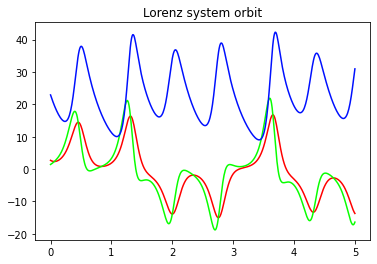

In [11]:
plot_colored(tr, Utr, sys_colors)
plt.title("Lorenz system orbit")
plt.show()

<Figure size 432x288 with 0 Axes>

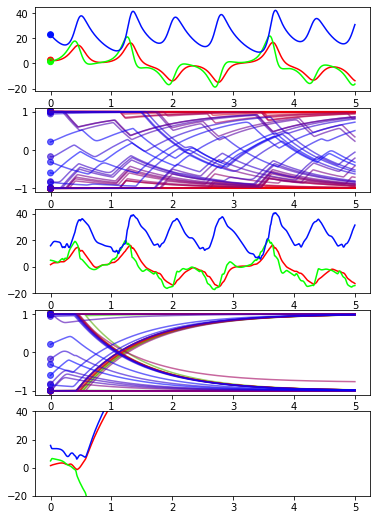

In [12]:
res = make_rescomp("activ_f")

resp_R = res.internal_state_response(tr, Utr, res.initial_condition(Utr[0,:]))
approx = resp_R @ res.W_out.T
pred_U, pred_R = res.predict(tr, u0=Utr[0,:], return_states=True)

init_err = Utr - approx
approx_deriv = (approx[1:,:]-approx[:-1,:])/0.01

order = sort_deriv_mag(resp_R)

plt.clf()
fig, ax = plt.subplots(5,1, figsize=(6,9))
plot_colored(tr, Utr, sys_colors, True, ax[0])
plot_colored(tr, resp_R[:,order], res_colors[::-1], True, ax[1], alpha=0.6)
plot_colored(tr, approx, sys_colors, False, ax[2])
#plot_colored(tr, init_err, sys_colors, False, ax[3])
#plot_colored(tr[:-1], approx_deriv, sys_colors, False, ax[4])
plot_colored(tr, pred_R[:,order], res_colors[::-1], True, ax[3], alpha=0.6)
plot_colored(tr, pred_U, sys_colors, False, ax[4])
ax[4].axis((None,None,-20,40))
plt.show()

In [13]:
from scipy.io import loadmat

def load_robo(filename):
    """Load soft robot data"""
    data = loadmat('../../Data/' + filename)
    t = data['t'][0]
    q = data['q']
    pref = data["pref"]
    return t, q, pref

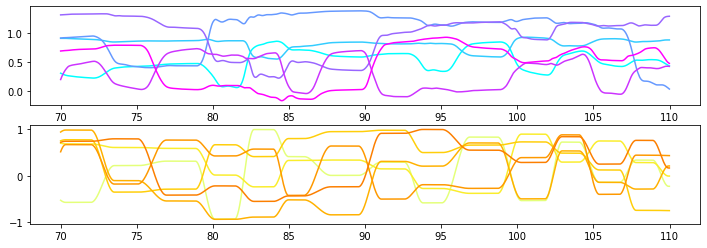

In [21]:
rt, rq, pref = load_robo("bellows_arm1_whitened.mat")

rob_colors = plt.get_cmap('cool')(np.linspace(0,1,6))
rob_p_colors = plt.get_cmap('Wistia')(np.linspace(0,1,6))

fig, ax = plt.subplots(2,1,figsize=(12,4))

n=7000
plot_colored(rt[n:n+4000], rq[n:n+4000,:], rob_colors, False, ax[0])
plot_colored(rt[n:n+4000], pref[n:n+4000,:], rob_p_colors, False, ax[1])
plt.show()

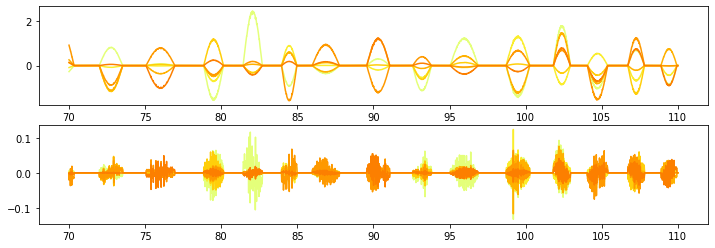

In [27]:
fig, ax = plt.subplots(2,1,figsize=(12,4))
plot_colored(rt[n:n+4000], (pref[n+1:n+4001,:]-pref[n-1:n+3999,:])/(rt[n+1:n+4001]-rt[n-1:n+3999]).reshape(-1,1), rob_p_colors, False, ax[0])
plot_colored(rt[n:n+4000], (pref[n+1:n+4001,:]-2*pref[n:n+4000,:]+pref[n-1:n+3999,:])/(rt[n+1:n+4001]-rt[n-1:n+3999]).reshape(-1,1), rob_p_colors, False, ax[1])
plt.show()